# Transshipments

In [268]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pycountry

In [269]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.2)

In [270]:
wd = "/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/"

In [271]:
carriers = pd.read_excel(wd + 'port_evaluation/data/proc/GFW/gfw_data-v2.xlsx', sheet_name='carriers')
loiter = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/loitering.csv')
encounter = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/encounter.csv')
port_visit = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/port_visit.csv')

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_7321/3556726673.py:2: DtypeWarning: Columns (10,11,12,13,14,41,42,43,46) have mixed types. Specify dtype option on import or set low_memory=False.
  loiter = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/loitering.csv')
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_7321/3556726673.py:3: DtypeWarning: Columns (43,46,53) have mixed types. Specify dtype option on import or set low_memory=False.
  encounter = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/encounter.csv')
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_7321/3556726673.py:4: DtypeWarning: Columns (6,7,8,9,12,22,25,26,29,33,34,35,37,38,41,42,43,44,46,47,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  port_visit = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/port_visit.csv')


In [272]:
country_data = [[country.alpha_3, country.alpha_2, country.name] for country in pycountry.countries]
country_data = pd.DataFrame(country_data, columns=['alpha_3', 'alpha_2', 'flag_country'])
rename_dict = {'Korea, Republic of': 'Korea', 'Taiwan, Province of China': 'Taiwan', 'Russian Federation': 'Russia'}
for country in rename_dict.keys():
    country_data.loc[country_data['flag_country'] == country, 'flag_country'] = rename_dict[country]

Preprocessing

In [273]:
## merging loitering with carrier data
carriers['imo'] = carriers['imo'].replace(0,np.nan)
carriers = carriers.merge(country_data, left_on='flag', right_on='alpha_3', how='left')
loitering = loiter.merge(carriers, left_on='vessel.id', right_on='id', how='left', suffixes=('_loitering', '_carrier')) ## all but 2 vessel.ids match between datasets.

Summary statistics

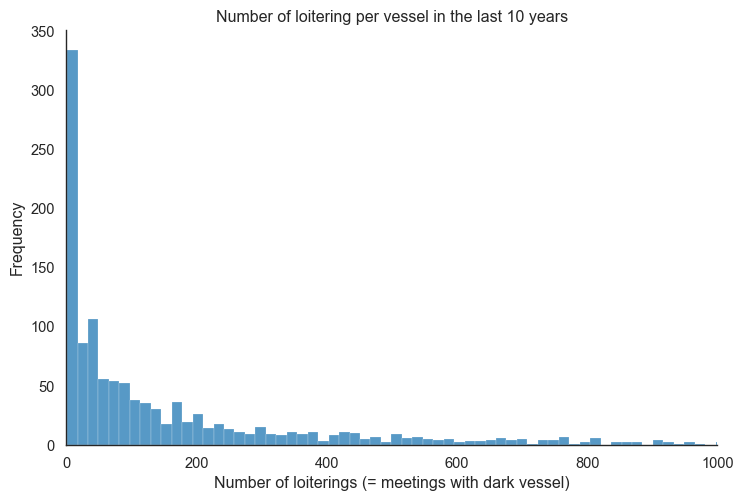

The median is 73.0.


In [274]:
plot_data = loitering.loc[:,'imo'].value_counts().reset_index()
sns.displot(data=plot_data, x="imo", kind="hist", bins = 300, aspect = 1.5)
plt.xlim(0,1000) 
plt.title('Number of loitering per vessel in the last 10 years')
plt.xlabel('Number of loiterings (= meetings with dark vessel)')
plt.ylabel('Frequency')
plt.show()
print("The median is {median}.".format(median=plot_data['imo'].median()))

Share responsible

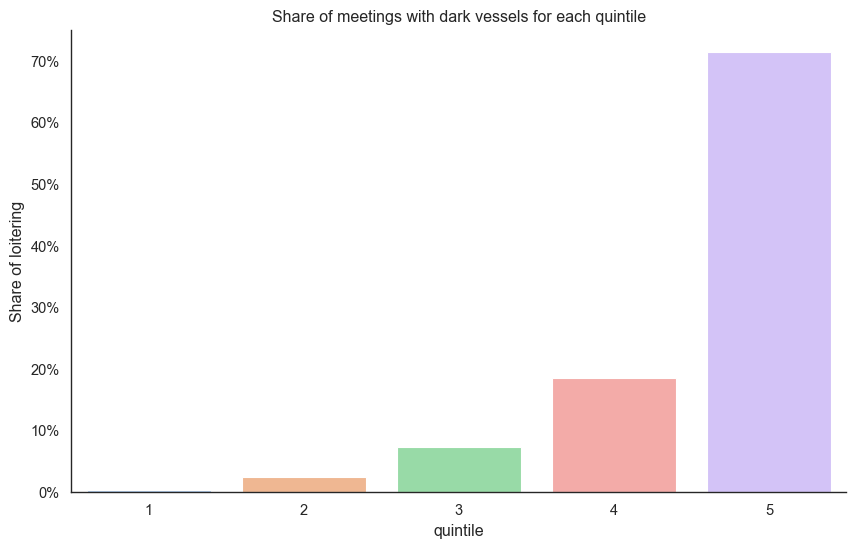

In [275]:
running_sum = 0
sum = []
share = []
for quintile in range(0,5):
    quantile = (quintile + 1)/5
    amount = plot_data['imo'].quantile(quantile)
    sum.append(plot_data.loc[plot_data['imo']<=amount,'imo'].sum() - running_sum)
    running_sum += sum[-1]
    share.append(sum[-1]/plot_data['imo'].sum() * 100)
quintiles = pd.DataFrame({'quintile' : range(1,6), 'share': share})

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = "quintile",
              y = "share",
              data = quintiles,
              ax = ax,
              palette="pastel")
handles, labels = ax.get_legend_handles_labels()
sns.despine(right = True)
plt.ylabel('Share of loitering')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Share of meetings with dark vessels for each quintile')
plt.show()

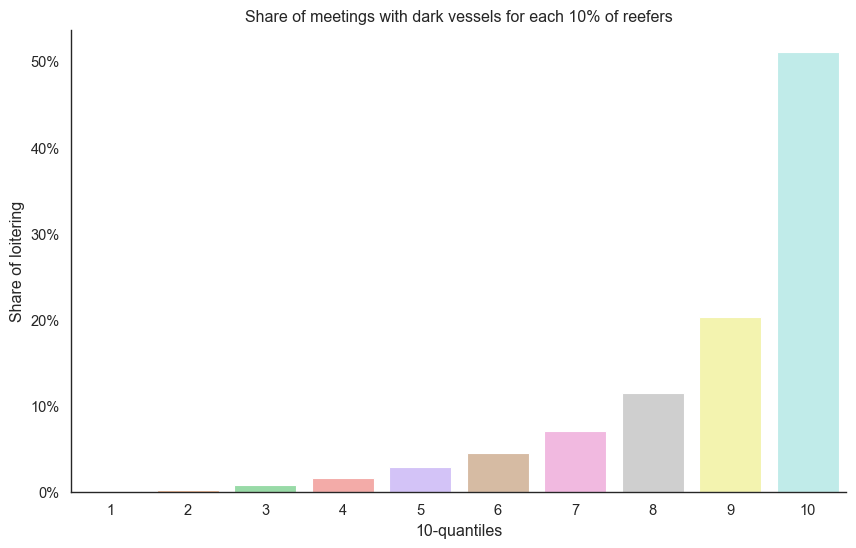

In [276]:
running_sum = 0
sum = []
share = []
for quintile in range(0,10):
    quantile = (quintile + 1)/10
    amount = plot_data['imo'].quantile(quantile)
    sum.append(plot_data.loc[plot_data['imo']<=amount,'imo'].sum() - running_sum)
    running_sum += sum[-1]
    share.append(sum[-1]/plot_data['imo'].sum() * 100)
quintiles = pd.DataFrame({'10-quantiles' : range(1,11), 'share': share})

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = "10-quantiles",
              y = "share",
              data = quintiles,
              ax = ax,
              palette="pastel")
handles, labels = ax.get_legend_handles_labels()
sns.despine(right = True)
plt.ylabel('Share of loitering')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Share of meetings with dark vessels for each 10% of reefers')
plt.show()

Cutoff for loitering

In [277]:
plot_data['imo'].quantile(.9)

546.8000000000002

Number of ships

In [278]:
len(plot_data.loc[plot_data['imo']>=549.49,'imo'])

120

In [279]:
top_10_percent = plot_data.loc[plot_data['imo']>=549.49,:]
loitering_top = loitering.loc[loitering['imo'].isin(top_10_percent['index']),:]

In [280]:
plot_data2 = top_10_percent.rename({'imo': 'n_dark_meetups'}, axis=1).merge(carriers, how='left', left_on='index', right_on='imo')
plot_data3 = plot_data2.groupby('flag_country')['imo'].nunique().reset_index().sort_values('imo')
# sns.displot(data=plot_data2, x="flag", kind="hist", bins = 300, aspect = 1.5)
# plt.show()

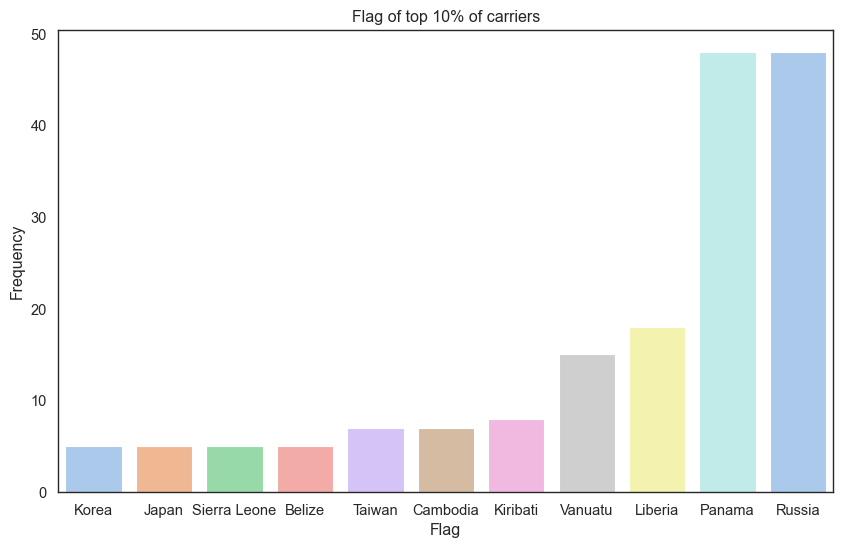

In [281]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data3.iloc[21:,:], 
    x='flag_country', 
    y='imo', 
    ax = ax,
    palette="pastel")
plt.title('Flag of top 10% of carriers')
plt.ylabel('Frequency')
plt.xlabel('Flag')
plt.show()

Additional analysis:

- which boats they each encountered
- length and size (using SeaVision)

## Location of meetups

In [282]:
plot_data

,index,imo
0,8831572.0,4823
1,8708139.0,3265
2,8610277.0,2928
3,8421274.0,2851
4,9012331.0,2825
...,...,...
1202,410161520.0,1
1203,8615227.0,1
1204,9920423.0,1
1205,7805241.0,1


In [283]:
loitering.columns

Index(['id_loitering', 'type', 'start', 'end', 'lat', 'lon', 'vessel.id',
       'vessel.type', 'vessel.mmsi', 'vessel.name', 'vessel.flag',
       'vessel.origin_port.country', 'vessel.origin_port.name',
       'vessel.destination_port.country', 'vessel.destination_port.name',
       'vessel.authorizations.authorized', 'vessel.authorizations.unknown',
       'median_speed_knots', 'elevation_m', 'distance_from_shore_m',
       'distance_from_port_m', 'regions.rfmo', 'encounter.median_distance_km',
       'encounter.authorization_status', 'encounter.encountered_vessel.id',
       'encounter.encountered_vessel.type',
       'encounter.encountered_vessel.mmsi',
       'encounter.encountered_vessel.name',
       'encounter.encountered_vessel.flag',
       'encounter.encountered_vessel.origin_port.country',
       'encounter.encountered_vessel.origin_port.name',
       'encounter.encountered_vessel.destination_port.country',
       'encounter.encountered_vessel.destination_port.name',
     